In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
df = pd.read_csv("../data/Iris.csv")
y = df["Species"]
X = df.loc[:, df.columns != "Species"].drop("Id", axis=1)

ohe = OneHotEncoder(handle_unknown="ignore")
y_ohe = ohe.fit_transform(y.values.reshape(-1, 1))
y_ohe = pd.DataFrame(y_ohe.toarray(), columns=ohe.get_feature_names_out())

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y_ohe, random_state=42, train_size=0.8
)

In [3]:
n_components = 4  # 主成分の数
pls = PLSRegression(n_components=n_components)
pls.fit(X_train, y_train)
T = pls.transform(X_train)[:, :2]

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


def plot_2d_gaussian_pdf(
    mean,
    cov,
    ax=None,
    x_range=(-5, 5),
    y_range=(-5, 5),
    steps=100,
    alpha=0.9,
    cmap="viridis",
    n_levels=10,
    vmin=0.1,
):
    if ax is None:
        ax = plt.gca()

    x = np.linspace(x_range[0], x_range[1], steps)
    y = np.linspace(y_range[0], y_range[1], steps)
    X, Y = np.meshgrid(x, y)

    # (steps*steps, 2) の形にして pdf を計算
    xy_pos = np.dstack([X, Y])  # shape: (steps, steps, 2)

    # 2次元正規分布オブジェクトを生成して PDF を計算
    rv = multivariate_normal(mean=mean, cov=cov)
    Z = rv.pdf(xy_pos)
    Z = np.where(Z < vmin, np.nan, Z)
    ax.contourf(X, Y, Z, levels=n_levels, cmap=cmap, alpha=alpha)

    return ax

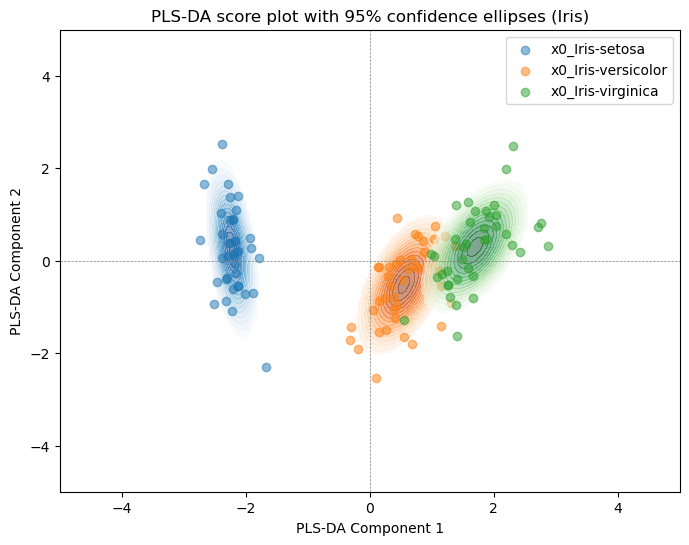

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

colors = ["tab:blue", "tab:orange", "tab:green"]
cmaps = ["Blues", "Oranges", "Greens"]
for i, col in enumerate(y_train.columns):
    mask = y_train[col] == 1
    X_g = T[mask]

    mean_g = np.mean(X_g, axis=0)
    cov_g = np.cov(X_g, rowvar=False)
    plot_2d_gaussian_pdf(
        mean_g,
        cov_g,
        ax=ax,
        x_range=(-5, 5),
        y_range=(-5, 5),
        steps=200,
        alpha=0.5,
        cmap=cmaps[i],
        n_levels=15,
    )
    ax.scatter(X_g[:, 0], X_g[:, 1], color=colors[i], alpha=0.5, label=col)

ax.axhline(0, color="gray", linestyle="--", linewidth=0.5)
ax.axvline(0, color="gray", linestyle="--", linewidth=0.5)
ax.set_xlabel("PLS-DA Component 1")
ax.set_ylabel("PLS-DA Component 2")
ax.legend()
ax.set_title("PLS-DA score plot with 95% confidence ellipses (Iris)")
plt.show()